In [27]:
import pandas as pd
import re

# pobranie danych z bazy OncoKB
df_onco = pd.read_csv('/kaggle/input/oncokb/cancerGeneList.tsv', sep='\t')
df_onco = df_onco[df_onco['Vogelstein']=='Yes'] # filtracja po Volgnetstein
hugos = df_onco['Hugo Symbol']

hugos.shape

(125,)

In [28]:
from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [29]:
# Rekordy somatycznych mutacji dla genów z OncoKB

hugo_list=hugos.to_list()

query = """SELECT *
FROM `isb-cgc-bq.TCGA.masked_somatic_mutation_hg38_gdc_current`
WHERE Variant_Type IN ("SNP", "DEL", "INS") 
AND Hugo_Symbol IN UNNEST(%s);
"""% hugo_list

query_job = client.query(query)
df = query_job.to_dataframe()

# format Parquet
df.to_parquet('/kaggle/working/mutations.parquet')
df_parquet = pd.read_parquet('mutations.parquet')

df_parquet.head()

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,project_short_name,case_barcode,primary_site,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,...,callers,file_gdc_id,muse,mutect2,pindel,varscan2,sample_barcode_tumor,sample_barcode_normal,aliquot_barcode_tumor,aliquot_barcode_normal
0,TCGA-COAD,TCGA-5M-AAT6,Colon,KLF4,9314,BCM,GRCh38,chr9,107488024,107488024,...,muse;mutect2;varscan2,9a373792-babb-4744-a23c-eb4ee170e6de,Yes,Yes,No,Yes,TCGA-5M-AAT6-01A,TCGA-5M-AAT6-10A,TCGA-5M-AAT6-01A-11D-A40P-10,TCGA-5M-AAT6-10A-01D-A40P-10
1,TCGA-UCEC,TCGA-A5-A0G2,Corpus uteri,DAXX,1616,WUGSC,GRCh38,chr6,33321883,33321883,...,muse;mutect2;varscan2,411a606d-f354-4561-b42c-eb1bc155c87d,Yes,Yes,No,Yes,TCGA-A5-A0G2-01A,TCGA-A5-A0G2-10A,TCGA-A5-A0G2-01A-11W-A062-09,TCGA-A5-A0G2-10A-01W-A062-09
2,TCGA-COAD,TCGA-A6-6648,Colon,PHF6,84295,BCM,GRCh38,chrX,134413609,134413609,...,muse;mutect2;varscan2,df4bd1d4-36c1-4819-8e7d-3a684cb70824,Yes,Yes,No,Yes,TCGA-A6-6648-01A,TCGA-A6-6648-10A,TCGA-A6-6648-01A-11D-1771-10,TCGA-A6-6648-10A-01D-1771-10
3,TCGA-UCEC,TCGA-BG-A0YU,Corpus uteri,AKT1,207,WUGSC,GRCh38,chr14,104780214,104780214,...,muse;mutect2;varscan2,efce7c74-4ceb-409c-9a43-4b8490695651,Yes,Yes,No,Yes,TCGA-BG-A0YU-01A,TCGA-BG-A0YU-10A,TCGA-BG-A0YU-01A-21D-A10M-09,TCGA-BG-A0YU-10A-01D-A10M-09
4,TCGA-UCEC,TCGA-E6-A1M0,Corpus uteri,TNFAIP3,7128,WUGSC,GRCh38,chr6,137874936,137874936,...,muse;mutect2;varscan2,8a0ff8a3-c55d-48f1-b06f-ae044a5036d4,Yes,Yes,No,Yes,TCGA-E6-A1M0-01A,TCGA-E6-A1M0-10A,TCGA-E6-A1M0-01A-11D-A142-09,TCGA-E6-A1M0-10A-01D-A142-09


In [31]:
import re

df_parquet = df_parquet.rename(columns={'Start_Position': 'Start'})
df_parquet = df_parquet.rename(columns={'End_Position': 'End'})

In [32]:
# Profil ekspresji RNA, usunięcie duplikatów i zapis w Parquet

query = """SELECT *
FROM `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current` 
WHERE gene_name IN UNNEST(%s);
"""% hugo_list

query_job = client.query(query)
df = query_job.to_dataframe()

# format Parquet
df.to_parquet('/kaggle/working/expressions.parquet')
df_expressions = pd.read_parquet('expressions.parquet')
df_expressions = df_expressions.drop_duplicates(subset=['gene_name', 'case_barcode'])
df_expressions.head()

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,project_short_name,primary_site,case_barcode,sample_barcode,aliquot_barcode,gene_name,gene_type,Ensembl_gene_id,Ensembl_gene_id_v,unstranded,...,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded,sample_type_name,case_gdc_id,sample_gdc_id,aliquot_gdc_id,file_gdc_id,platform
0,TCGA-ACC,Adrenal gland,TCGA-OR-A5JB,TCGA-OR-A5JB-01A,TCGA-OR-A5JB-01A-11R-A29S-07,NRAS,protein_coding,ENSG00000213281,ENSG00000213281.5,1901,...,967,27.8642,9.5155,10.0667,Primary Tumor,d63f2f1e-1970-445f-907b-23cf4d9efd83,0c98b45d-09a6-48a6-89ba-48ba7a2142d5,26861b93-29de-42df-80d6-23260d450391,5caed5c6-43ad-4d9b-b29b-398ade676797,Illumina
1,TCGA-ACC,Adrenal gland,TCGA-OR-A5JB,TCGA-OR-A5JB-01A,TCGA-OR-A5JB-01A-11R-A29S-07,CARD11,protein_coding,ENSG00000198286,ENSG00000198286.10,387,...,198,5.3024,1.8107,1.9156,Primary Tumor,d63f2f1e-1970-445f-907b-23cf4d9efd83,0c98b45d-09a6-48a6-89ba-48ba7a2142d5,26861b93-29de-42df-80d6-23260d450391,5caed5c6-43ad-4d9b-b29b-398ade676797,Illumina
2,TCGA-ACC,Adrenal gland,TCGA-OR-A5JB,TCGA-OR-A5JB-01A,TCGA-OR-A5JB-01A-11R-A29S-07,TRAF7,protein_coding,ENSG00000131653,ENSG00000131653.13,2323,...,2051,32.8133,11.2057,11.8547,Primary Tumor,d63f2f1e-1970-445f-907b-23cf4d9efd83,0c98b45d-09a6-48a6-89ba-48ba7a2142d5,26861b93-29de-42df-80d6-23260d450391,5caed5c6-43ad-4d9b-b29b-398ade676797,Illumina
3,TCGA-ACC,Adrenal gland,TCGA-OR-A5JB,TCGA-OR-A5JB-01A,TCGA-OR-A5JB-01A-11R-A29S-07,SOX9,protein_coding,ENSG00000125398,ENSG00000125398.8,276,...,142,4.4520,1.5204,1.6084,Primary Tumor,d63f2f1e-1970-445f-907b-23cf4d9efd83,0c98b45d-09a6-48a6-89ba-48ba7a2142d5,26861b93-29de-42df-80d6-23260d450391,5caed5c6-43ad-4d9b-b29b-398ade676797,Illumina
4,TCGA-ACC,Adrenal gland,TCGA-OR-A5JB,TCGA-OR-A5JB-01A,TCGA-OR-A5JB-01A-11R-A29S-07,ARID1A,protein_coding,ENSG00000117713,ENSG00000117713.20,2586,...,1297,10.2877,3.5132,3.7167,Primary Tumor,d63f2f1e-1970-445f-907b-23cf4d9efd83,0c98b45d-09a6-48a6-89ba-48ba7a2142d5,26861b93-29de-42df-80d6-23260d450391,5caed5c6-43ad-4d9b-b29b-398ade676797,Illumina


In [34]:
# Zbiór etykiet primary site jest niezbalansowany

df_parquet['primary_site'].value_counts()

primary_site
Corpus uteri                                                              10424
Bronchus and lung                                                          5875
Colon                                                                      4881
Skin                                                                       3755
Brain                                                                      3314
Stomach                                                                    3178
Bladder                                                                    2778
Breast                                                                     2737
Kidney                                                                     1373
Cervix uteri                                                               1361
Liver and intrahepatic bile ducts                                          1045
Ovary                                                                       993
Rectum                     

In [35]:
!pip install biopython pyranges

!wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz

--2025-06-22 19:48:18--  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M  25.6MB/s    in 28s     

2025-06-22 19:48:46 (33.6 MB/s) - ‘hg38.fa.gz’ saved [983659424/983659424]

gzip: hg38.fa already exists; do you wish to overwrite (y or n)? ^C


In [36]:
# ekstrakcja trójnukleotydowego kontekstu

import pyranges as pr
import pandas as pd
from Bio import SeqIO

gr = pr.PyRanges(df_parquet)
fasta_sequences = SeqIO.to_dict(SeqIO.parse("/kaggle/working/hg38.fa", "fasta"))

In [37]:
def get_cosmic_notation(row, fasta_dict):
    chrom = row.Chromosome  # upewniamy się, że chromosom nie ma prefiksu "chr"
    start = int(row.Start)
    end = int(row.End)
    alt = str(row.Tumor_Seq_Allele2) if pd.notnull(row.Tumor_Seq_Allele2) else None
    variant_type = row.Variant_Type
    cosmic_notation = None

    try:
        seq = fasta_dict[chrom].seq
        context_seq = seq[start-2:end+1].upper()  # np. G[C>T]A -> 1 baza przed i po
        ref_base = seq[start-1:end].upper()  

        # COSMIC-style notacja
        if variant_type == 'SNP':
            # np. G[C>T]A
            cosmic_notation = f"{context_seq[0]}[{ref_base}>{alt}]{context_seq[-1]}"

        elif variant_type == 'DEL':
            if end > start:
                deleted_seq = seq[start-1:end].upper()
            else:
                deleted_seq = ref_base
            cosmic_notation = f"{context_seq[0]}[del{len(deleted_seq)}]{context_seq[-1]}"

        elif variant_type == 'INS':
            inserted_seq = alt
            cosmic_notation = f"{context_seq[0]}[ins{len(inserted_seq)}]{context_seq[-1]}"

        else:
            cosmic_notation = f"UnknownVariantType:{variant_type}"

    except Exception as e:
        cosmic_notation = f"ERROR: {e}"

    return cosmic_notation


In [38]:
df_parquet['Mutational_Motif'] = df_parquet.apply(lambda row: get_cosmic_notation(row, fasta_sequences), axis=1)

In [39]:
# normalizacja do pirymidyn, komplementacja

complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

def normalize_mutation(mutation):
    match = re.match(r"([ATGC])\[([ATGC]>[ATGC])\]([ATGC])", mutation)
    if match:
        ref, change, alt = match.groups()
        ref_from, ref_to = change.split('>')

        if ref_from not in ['C', 'T']:
            ref_from = complement[ref_from]
            ref_to = complement[ref_to]
            ref = complement[alt]
            alt = complement[ref]

        return f"{ref}[{ref_from}>{ref_to}]{alt}"

    return mutation


df_parquet['MutationType'] = df_parquet['Mutational_Motif'].apply(normalize_mutation)

In [40]:
# Genomowe binowanie

df_parquet['Genomic_Bin'] = df_parquet['Chromosome'].astype(str) + '_' + (
    ((df_parquet['Start'] - 1) // 1_000_000) * 1_000_000).astype(str)

In [41]:
# zgrupowanie danych
grouped_mutations_df = df_parquet.groupby('case_barcode').agg({
    'MutationType': list,
    'Genomic_Bin': list,
    'Hugo_Symbol': list,
    'primary_site': 'first',
}).reset_index()

grouped_expression_df = df_expressions.groupby('case_barcode').agg({
    'gene_name': list,
    'tpm_unstranded': list,
}).reset_index()

grouped_df = pd.merge(grouped_mutations_df, grouped_expression_df, on="case_barcode", suffixes=('_mutation', '_expression'))

In [42]:
# tokenizacja

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

def to_matrix(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    count_vectors = np.zeros((len(texts), len(tokenizer.word_index) + 1))

    for i, seq in enumerate(sequences):
        for token in seq:
            count_vectors[i, token] += 1

    return count_vectors

In [43]:
tokenizer_bin = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_bin.fit_on_texts(df_parquet['Genomic_Bin'].astype(str).to_list())

tokenizer_gene = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_gene.fit_on_texts(df_parquet['Hugo_Symbol'].astype(str).to_list())

tokenizer_motif = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_motif.fit_on_texts(df_parquet['MutationType'].astype(str).to_list())

In [44]:
def prepare_data_for(df, tokenizer_bin, tokenizer_gene, tokenizer_motif):
    X_bin = to_matrix(tokenizer_bin, df['Genomic_Bin'])
    X_gene = to_matrix(tokenizer_gene, df['Hugo_Symbol'])
    X_motif = to_matrix(tokenizer_motif, df['MutationType'])

    # normalizacja przez logarytmowanie
    X_rna = np.log1p(np.array(df['tpm_unstranded'].to_list()))

    return X_bin, X_gene, X_motif, X_rna

In [45]:
# konkatenacja

X_genomic_bin, X_gene, X_motif, X_rna = prepare_data_for(grouped_df, tokenizer_bin, tokenizer_gene, tokenizer_motif)
X = np.concatenate([X_genomic_bin, X_gene, X_motif, X_rna], axis=1)

# etykiety y

y_primary_site = grouped_df['primary_site']

In [46]:
print(X.shape, X_genomic_bin.shape, X_gene.shape, X_motif.shape, X_rna.shape, len(pd.unique(y_primary_site)))

(8370, 1085) (8370, 135) (8370, 127) (8370, 698) (8370, 125) 49


In [84]:
dimension = X.shape[0]
genomic_bin_features = X_genomic_bin.shape[1]
genomic_bin_start = 0

gene_features = X_gene.shape[1]
gene_start = X_genomic_bin.shape[1]

motif_features = X_motif.shape[1]
motif_start = X_genomic_bin.shape[1] + X_gene.shape[1]

rna_features = X_rna.shape[1]
rna_start = X_genomic_bin.shape[1] + X_gene.shape[1] + X_motif.shape[1]

output_dim = len(pd.unique(y_primary_site))

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim


# Definicja modelu
class SimpleModel(nn.Module):
   def __init__(self):
       super(SimpleModel, self).__init__()

       # wejścia dla każdej grupy cech
       self.fc_genomic_bin = nn.Linear(genomic_bin_features, dimension)
       self.fc_gene = nn.Linear(gene_features, dimension)
       self.fc_motif = nn.Linear(motif_features, dimension)
       self.fc_rna = nn.Linear(rna_features, dimension)

       # wartswy ukryte, wyjście i relu
       self.fc1 = nn.Linear(4*dimension, 256)
       self.fc2 = nn.Linear(256, 64)
       self.out = nn.Linear(64, output_dim)
       self.relu = nn.ReLU()

   def forward(self, x):
       x_genomic_bin = x[:, genomic_bin_start:(genomic_bin_start+genomic_bin_features)]
       x_gene = x[:, gene_start:(gene_start+gene_features)]
       x_motif = x[:, motif_start:(motif_start+motif_features)]
       x_rna = x[:, rna_start:(rna_start+rna_features)]

       
       # wejścia dla każdej grupy cech
       x_genomic_bin = self.fc_genomic_bin(x_genomic_bin)
       x_genomic_bin = self.relu(x_genomic_bin)
       
       x_gene = self.fc_gene(x_gene)
       x_gene = self.relu(x_gene)
       
       x_motif = self.fc_motif(x_motif)
       x_motif = self.relu(x_motif)
       
       x_rna = self.fc_rna(x_rna)
       x_rna = self.relu(x_rna)

       # konkatenacja
       x = torch.cat((x_genomic_bin, x_gene, x_motif, x_rna), dim=1)
       
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.out(x)

       return x

model = SimpleModel()

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# zakodowanie primary site jako kategorie
le = LabelEncoder()
y_encoded = le.fit_transform(y_primary_site)

X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).view(-1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).view(-1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).view(-1)

In [87]:
from sklearn.utils.class_weight import compute_class_weight

# Funkcja straty i optymalizator
# Wagi klas (uwzględnienie niezbalansowanych etykiet)

all_classes = np.arange(len(le.classes_))  # pełny zakres zakodowanych klas
train_classes = np.unique(y_train)

# Wagi tylko dla danych treningowych
train_weights = compute_class_weight(
    class_weight='balanced',
    classes=train_classes,
    y=y_train
)
weight_dict = dict(zip(train_classes, train_weights))

# ) dla klas, których nie ma w zestawie treningowym
full_weights = [weight_dict.get(cls, 0.0) for cls in all_classes]
class_weights_tensor = torch.tensor(full_weights, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # softmax uwzględniony tutaj
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
precision_list =[]
recall_list = []
f1_list = []

for epoch in range(101):
    # --- Trening ---
    model.train()

    # train loss
    y_pred_train = model(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    train_loss_list.append(loss.item())
    
    # train accuracy
    _, predicted_train = torch.max(y_pred_train, 1)
    acc_train = (predicted_train == y_train_tensor).float().mean().item()
    train_acc_list.append(acc_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # --- Walidacja ---
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            
            # val loss
            y_pred_val = model(X_val_tensor)
            val_loss = criterion(y_pred_val, y_val_tensor)
            val_loss_list.append(val_loss.item())

            # val accuracy
            _, predicted_val = torch.max(y_pred_val, 1)
            acc_val = (predicted_val == y_val_tensor).float().mean().item()
            val_acc_list.append(acc_val)

            # konwersja do numpy
            y_true_np = y_val_tensor.cpu().numpy()
            y_pred_np = predicted_val.cpu().numpy()
        
            # precyzja, recall, f1 (ważone, żeby uwzględnić niezbalansowanie klas)
            precision = precision_score(y_true_np, y_pred_np, zero_division=0, average='weighted')
            precision_list.append(precision)
            
            recall = recall_score(y_true_np, y_pred_np, zero_division=0, average='weighted')
            recall_list.append(recall)
            
            f1 = f1_score(y_true_np, y_pred_np, average='weighted')
            f1_list.append(f1)

            print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Train Acc = {acc_train:.4f}, Val Loss = {val_loss.item():.4f}, Val Acc = {acc_val:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Epoch 0: Train Loss = 3.8927, Train Acc = 0.0061, Val Loss = 54.9727, Val Acc = 0.0015, Precision: 0.0000, Recall: 0.0015, F1: 0.0000
Epoch 20: Train Loss = 1.9614, Train Acc = 0.2937, Val Loss = 4.4898, Val Acc = 0.2776, Precision: 0.4809, Recall: 0.2776, F1: 0.2913
Epoch 40: Train Loss = 0.4744, Train Acc = 0.7604, Val Loss = 8.7081, Val Acc = 0.4269, Precision: 0.4881, Recall: 0.4269, F1: 0.4485
Epoch 60: Train Loss = 0.1451, Train Acc = 0.9147, Val Loss = 13.9276, Val Acc = 0.4313, Precision: 0.4587, Recall: 0.4313, F1: 0.4371
Epoch 80: Train Loss = 0.0831, Train Acc = 0.9459, Val Loss = 16.5656, Val Acc = 0.4284, Precision: 0.4360, Recall: 0.4284, F1: 0.4261
Epoch 100: Train Loss = 0.0463, Train Acc = 0.9700, Val Loss = 18.7756, Val Acc = 0.4224, Precision: 0.4315, Recall: 0.4224, F1: 0.4222


In [89]:
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    _, predicted_test = torch.max(y_pred_test, 1)
    acc_test = (predicted_test == y_test_tensor).float().mean().item()
    
print(f"\nMSE na zbiorze testowym: {test_loss.item():.4f}, \n Accuracy na zbiorze testowym: {acc_test}.4f")


MSE na zbiorze testowym: 15.7273, 
 Accuracy na zbiorze testowym: 0.4456391930580139.4f


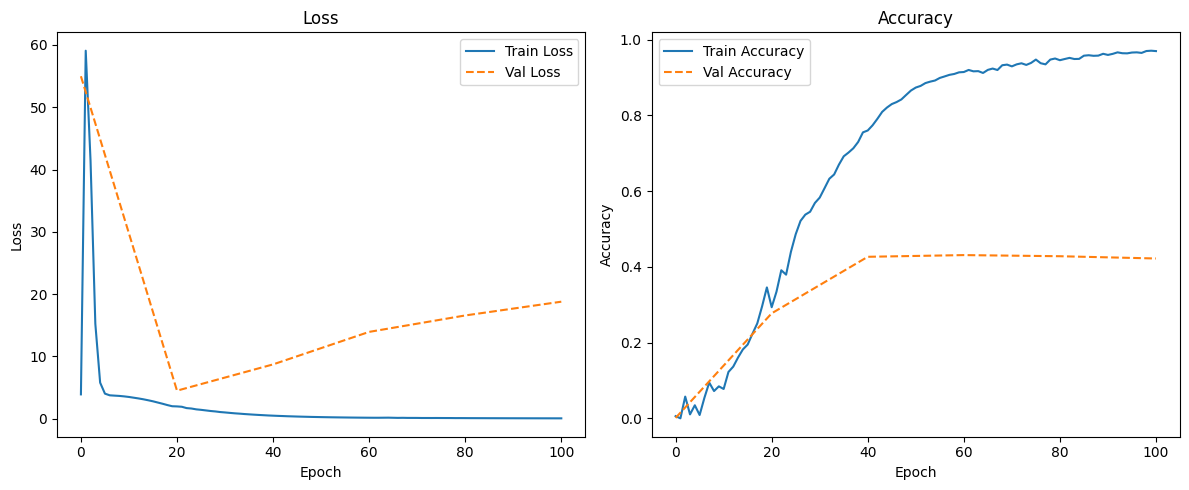

In [90]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(np.arange(0, 101, 20), val_loss_list, label='Val Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(np.arange(0, 101, 20), val_acc_list, label='Val Accuracy', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()

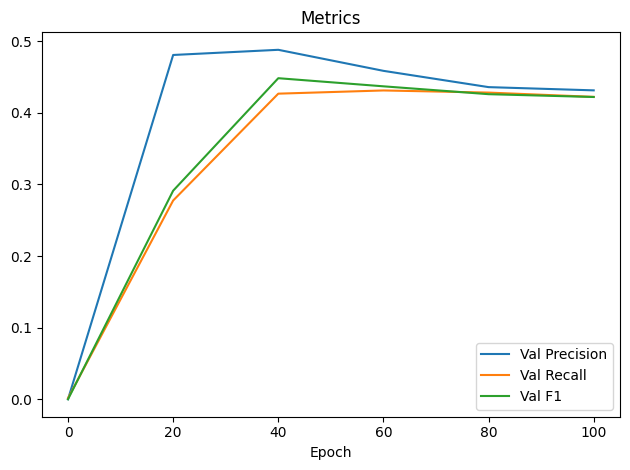

In [91]:
plt.plot(np.arange(0, 101, 20), precision_list, label='Val Precision')
plt.plot(np.arange(0, 101, 20), recall_list, label='Val Recall')
plt.plot(np.arange(0, 101, 20), f1_list, label='Val F1')
plt.xlabel("Epoch")
plt.legend()
plt.title("Metrics")

plt.tight_layout()
plt.show()